In [1]:
import sys
from matplotlib import pyplot as plt
from sklift.metrics import uplift_at_k
import seaborn as sns
import numpy as np
import pandas as pd
# install uplift library scikit-uplift and other libraries 
#!{sys.executable} -m pip install scikit-uplift dill catboost

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Load Dataset

We are going to use a Hillstrom dataset from the MineThatData [hosted](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html) in march 2008 by the president of this company Kevin Hillstrom.

MineThatData is a consulting company that helps CEO understand the complex relationship between Customers, Advertising, Products, Brands, and Channels.

## Data description

Dataset can be loaded from sklift.datasets module using fetch_hillstrom function.

Read more about dataset in the [api docs](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_hillstrom.html).

This dataset contains 64,000 customers who last purchased within twelve months. The customers were involved in an e-mail test

**Major columns**

- **visit** (binary): target. 1/0 indicator, 1 = Customer visited website in the following two weeks.

- **conversion** (binary): target. 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.

- **spend** (float): target. Actual dollars spent in the following two weeks.

- **segment** (str): treatment. The e-mail campaign the customer received

Read more in the [docs](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_hillstrom.html#hillstrom)

In [2]:
from sklift.datasets import fetch_hillstrom

# returns sklearn Bunch object
# with data, target, treatment keys
# data features (pd.DataFrame), target (pd.Series), treatment (pd.Series) values 
dataset = fetch_hillstrom()

In [3]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (64000, 8)
Dataset target shape: (64000,)
Dataset treatment shape: (64000,)


## EDA 

In [4]:
dataset.data.head().append(dataset.data.tail())

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel
63999,1,4) $350 - $500,472.82,0,1,Surburban,0,Web


In [5]:
#info about types and null cells in dataset
dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 3.9+ MB


There is no missing data in the cells! 

# Categorical data

In [6]:
cat_features = ['channel', 'zip_code', 'history_segment', 'newbie']

In [7]:
dataset.data.channel.unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [8]:
dataset.data.zip_code.unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [9]:
dataset.data.history_segment.unique()

array(['2) $100 - $200', '3) $200 - $350', '5) $500 - $750',
       '1) $0 - $100', '6) $750 - $1,000', '4) $350 - $500',
       '7) $1,000 +'], dtype=object)

**Zip code**

<AxesSubplot:>

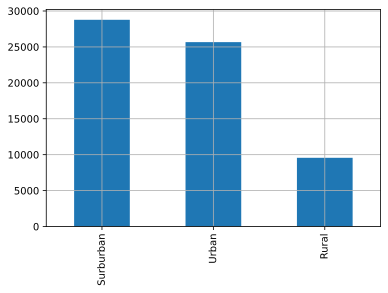

In [10]:
dataset.data.zip_code.value_counts().plot(kind = 'bar', grid=True)

**Channel**

<AxesSubplot:>

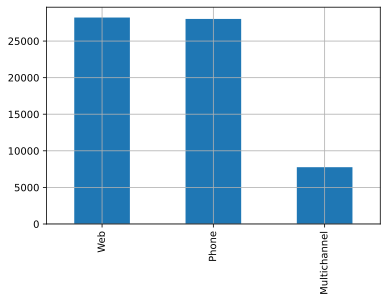

In [11]:
dataset.data.channel.value_counts().plot(kind = 'bar', grid=True)

**History segment**

<AxesSubplot:>

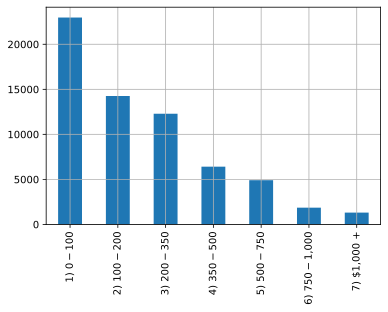

In [12]:
dataset.data.history_segment.value_counts().plot(kind = 'bar', grid=True)

In [13]:
#As option I propose to apply following function for transformation data in column "historic_segment"
def historic_segment_transform(dataset):
    for payment in dataset.data['history_segment'].unique(): 
        if payment =='1) $0 - $100':
            dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 50
        elif payment =='2) $100 - $200':
            dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 150
        elif payment =='3) $200 - $350':
            dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 275
        elif payment =='4) $350 - $500':
            dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 425
        elif payment =='5) $500 - $750':
            dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 575
        elif payment =='5) $750 - $1000':
            dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 825
        else:
            dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 1000
    return dataset.data.history_segment

In [14]:
dataset.data.history_segment.value_counts()

1) $0 - $100        22970
2) $100 - $200      14254
3) $200 - $350      12289
4) $350 - $500       6409
5) $500 - $750       4911
6) $750 - $1,000     1859
7) $1,000 +          1308
Name: history_segment, dtype: int64

<AxesSubplot:>

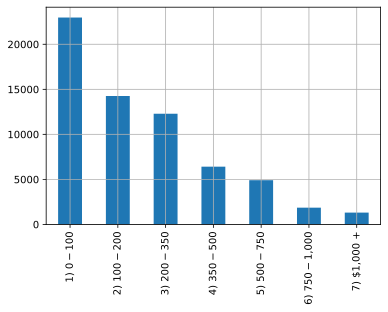

In [15]:
dataset.data.history_segment.value_counts().plot(kind = 'bar', grid=True)

In [16]:
#It's better to proceed from categorical to numeric data
# For example, we could replace 0-100 on average value 50 

<AxesSubplot:>

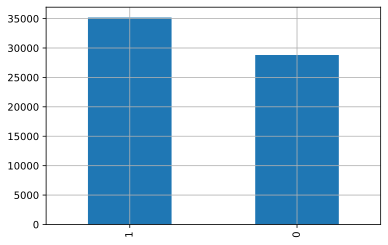

In [17]:
dataset.data.womens.value_counts().plot(kind = 'bar', grid=True)

<AxesSubplot:>

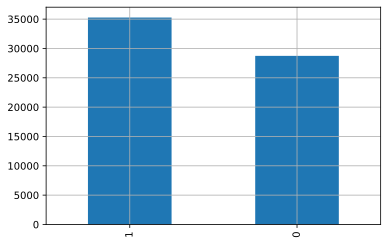

In [18]:
dataset.data.mens.value_counts().plot(kind = 'bar', grid=True)

In [19]:
dataset.data.womens.value_counts()

1    35182
0    28818
Name: womens, dtype: int64

In [20]:
dataset.data.groupby('womens').size()/dataset.data['womens'].count()*100

womens
0    45.028125
1    54.971875
dtype: float64

In [21]:
#55% - womens purchases
#44% - mens purchases

In [22]:
dataset.data.mens.value_counts()

1    35266
0    28734
Name: mens, dtype: int64

In [23]:
dataset.data.groupby('mens').size()/dataset.data['mens'].count()*100

mens
0    44.896875
1    55.103125
dtype: float64

In [24]:
#55% - mens purchases
#44% - womens purchases

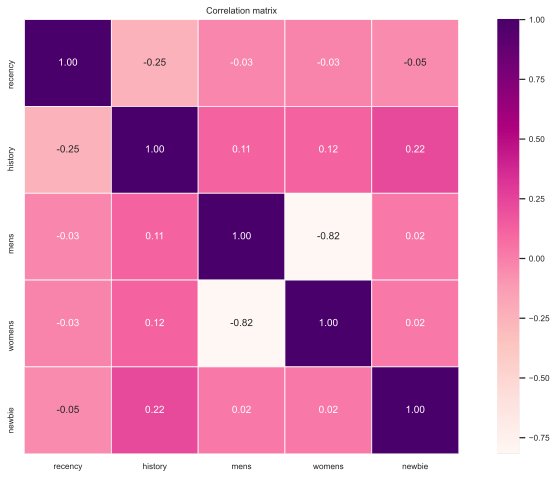

In [25]:
plt.figure(figsize = (14,8))

sns.set(font_scale=0.75)
sns.heatmap(dataset.data.corr().round(3), annot=True, square = True, linewidths=.75, cmap='RdPu', fmt = '.2f',annot_kws = {"size": 10} )

plt.title('Correlation matrix')
plt.show()

In [26]:
# womens and mens are in inverse correlation. I propose to make 1 column "gender" and merge.

In [27]:
# As we can see, there is high correlation between 'history_segment' and 'history'. Could we merge it also and transform columns to numeric data? 

# Numeric data

<AxesSubplot:>

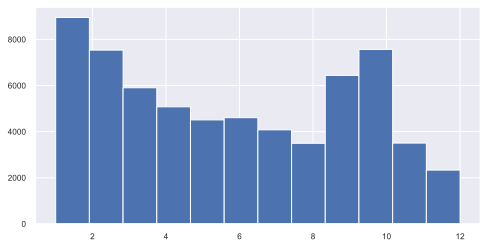

In [28]:
dataset.data.loc[:, 'recency'].hist(figsize=(8, 4), bins=12, grid=True)

In [29]:
dataset.data.history.value_counts()

29.99     7947
81.20        9
53.79        9
60.51        8
88.09        8
          ... 
200.53       1
234.76       1
239.91       1
99.85        1
738.50       1
Name: history, Length: 34833, dtype: int64

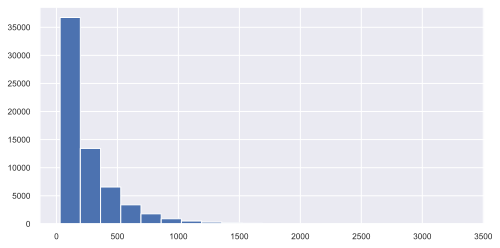

In [30]:
dataset.data.loc[:, 'history'].hist(figsize=(8, 4), bins=20, grid=True);

# Target data

In [31]:
#dataset_segment
dataset.treatment.head()

0    Womens E-Mail
1        No E-Mail
2    Womens E-Mail
3      Mens E-Mail
4    Womens E-Mail
Name: segment, dtype: object

In [32]:
dataset.treatment.unique()

array(['Womens E-Mail', 'No E-Mail', 'Mens E-Mail'], dtype=object)

<AxesSubplot:>

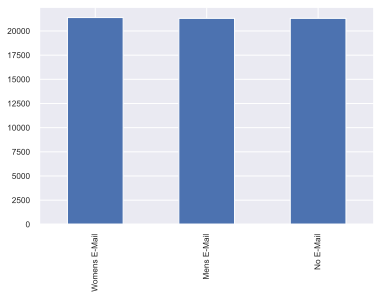

In [33]:
dataset.treatment.value_counts().plot(kind = 'bar', grid = 'True')

In [34]:
#dataset_visit
dataset.target.head()

0    0
1    0
2    0
3    0
4    0
Name: visit, dtype: int64

<AxesSubplot:>

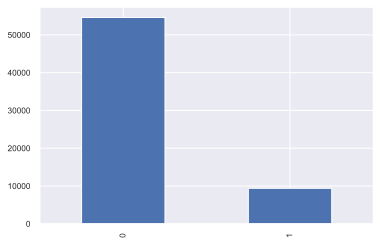

In [35]:
dataset.target.value_counts().plot(kind = 'bar')

In [36]:
#Target is disbalanced

In [37]:
import pandas as pd 

pd.crosstab(dataset.treatment, dataset.target, normalize='index')

visit,0,1
segment,,
Mens E-Mail,0.817243,0.182757
No E-Mail,0.893833,0.106167
Womens E-Mail,0.848600,0.151400


In [38]:
dataset.target.unique()

array([0, 1], dtype=int64)

Text(0.5, 1.0, 'Treatment & Target')

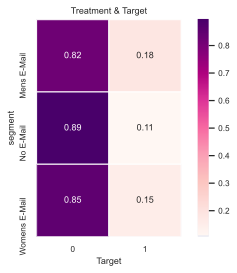

In [39]:
crosstab = pd.crosstab(dataset.treatment, dataset.target, normalize='index')
    
sns.heatmap(crosstab, annot=True, fmt=".2f", linewidths=1, square = True, cmap = 'RdPu')
plt.xlabel('Target')
plt.title("Treatment & Target")

In [40]:
#Let's consider two cases: 
#1) Womens E-mail - No E-mail
#2) Mens E-mail - No E-mail

## Womens E-mail - No E-mail

In [42]:
# make treatment binary
treat_dict_womens = {
            'Womens E-Mail': 1,
            'No E-Mail': 0, 
            'Mens E-Mail': 0
            }
dataset.treatment_womens = dataset.treatment.map(treat_dict_womens)

<AxesSubplot:>

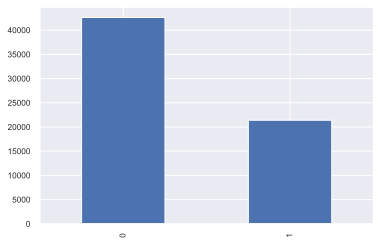

In [44]:
dataset.treatment_womens.value_counts().plot(kind = 'bar', grid = 'True')

In [45]:
stratify_cols = pd.concat([dataset.treatment_womens, dataset.target], axis=1)

In [46]:
stratify_cols.head(5)

,segment,visit
0,1,0
1,0,0
2,1,0
3,0,0
4,1,0


In [50]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([dataset.treatment_womens, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment_womens,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (44800, 8)
Validation shape: (19200, 8)


In [51]:
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

estimator = CatBoostClassifier(verbose=100, 
                               cat_features=['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie'],
                               random_state=42,
                               thread_count=1
                              )

ct_model = ClassTransformation(estimator=estimator)

In [52]:
ct_model.fit(
    X=X_train, 
    y=y_train, 
    treatment=trmnt_train
)

<ipython-input-52-cd313cbcd08e>:1: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct_model.fit(


Learning rate set to 0.052243
0:	learn: 0.6900041	total: 307ms	remaining: 5m 7s
100:	learn: 0.6610229	total: 13.5s	remaining: 1m 59s
200:	learn: 0.6594380	total: 26.7s	remaining: 1m 45s
300:	learn: 0.6569047	total: 42.9s	remaining: 1m 39s
400:	learn: 0.6546442	total: 1m	remaining: 1m 30s
500:	learn: 0.6523825	total: 1m 17s	remaining: 1m 17s
600:	learn: 0.6504138	total: 1m 38s	remaining: 1m 5s
700:	learn: 0.6482230	total: 1m 57s	remaining: 50.2s
800:	learn: 0.6463583	total: 2m 13s	remaining: 33.3s
900:	learn: 0.6445439	total: 2m 31s	remaining: 16.6s
999:	learn: 0.6427664	total: 2m 46s	remaining: 0us


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x000002A4F0164A60>)

In [53]:
#in progress with multiclassclassifier for Catboost. 

In [54]:
from sklift.metrics import uplift_at_k

In [57]:
uplift_predictions = ct_model.predict(X_val)

In [58]:
# k = 10%
k = 0.1  

# strategy='overall' sort by uplift treatment and control together
uplift_overall = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='overall', k=k)

# strategy='by_group' sort by uplift treatment and control separately
uplift_bygroup = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='by_group', k=k)


print(f"uplift@{k * 100:.0f}%: {uplift_overall:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup:.4f} (sort groups by uplift separately)")

uplift@10%: 0.0314 (sort groups by uplift together)
uplift@10%: 0.0333 (sort groups by uplift separately)


## Mens E-mail - No E-mail

In [60]:
treat_dict_mens = {
            'Mens E-Mail': 1,
            'No E-Mail': 0, 
            'Womens E-Mail': 0
            }
dataset.treatment_mens = dataset.treatment.map(treat_dict_mens)

In [61]:
dataset.treatment_mens = dataset.treatment.map(treat_dict_mens)

<AxesSubplot:>

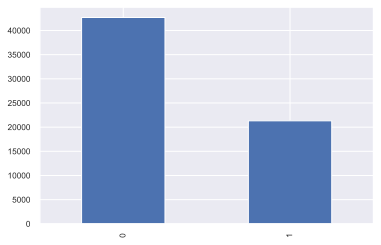

In [62]:
dataset.treatment_mens.value_counts().plot(kind = 'bar', grid = 'True')

In [63]:
stratify_cols = pd.concat([dataset.treatment_mens, dataset.target], axis=1)

In [64]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([dataset.treatment_mens, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment_mens,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (44800, 8)
Validation shape: (19200, 8)


In [65]:
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

estimator = CatBoostClassifier(verbose=100, 
                               cat_features=['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie'],
                               random_state=42,
                               thread_count=1
                              )

ct_model_mens = ClassTransformation(estimator=estimator)

In [66]:
ct_model_mens.fit(
    X=X_train, 
    y=y_train, 
    treatment=trmnt_train
)

<ipython-input-66-e628cd1d416a>:1: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct_model_mens.fit(


Learning rate set to 0.052243
0:	learn: 0.6888651	total: 196ms	remaining: 3m 16s
100:	learn: 0.6507044	total: 13.2s	remaining: 1m 57s
200:	learn: 0.6493217	total: 26.4s	remaining: 1m 44s
300:	learn: 0.6466936	total: 42.3s	remaining: 1m 38s
400:	learn: 0.6437030	total: 58.1s	remaining: 1m 26s
500:	learn: 0.6413201	total: 1m 14s	remaining: 1m 14s
600:	learn: 0.6390236	total: 1m 30s	remaining: 1m
700:	learn: 0.6366626	total: 1m 47s	remaining: 45.7s
800:	learn: 0.6342987	total: 2m 3s	remaining: 30.8s
900:	learn: 0.6322623	total: 2m 21s	remaining: 15.5s
999:	learn: 0.6303012	total: 2m 37s	remaining: 0us


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x000002A4F02320A0>)

In [67]:
uplift_predictions_mens = ct_model_mens.predict(X_val)

In [69]:
# k = 10%
k = 0.1  

# strategy='overall' sort by uplift treatment and control together
uplift_overall_mens = uplift_at_k(y_val, uplift_predictions_mens, trmnt_val, strategy='overall', k=k)

# strategy='by_group' sort by uplift treatment and control separately
uplift_bygroup_mens = uplift_at_k(y_val, uplift_predictions_mens, trmnt_val, strategy='by_group', k=k)


print(f"uplift@{k * 100:.0f}%: {uplift_overall_mens:.4f} (sort groups by uplift_mens together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup_mens:.4f} (sort groups by uplift_mens separately)")

uplift@10%: 0.0654 (sort groups by uplift_mens together)
uplift@10%: 0.0635 (sort groups by uplift_mens separately)
